In [ ]:
# Data download
# kaggle: https://www.kaggle.com/datasets/gaveshjain/ford-sentence-classifiaction-dataset/code

!wget -q --show-progress https://raw.githubusercontent.com/rambabar/NLP/main/data/ford_sentence_data.zip

ford_sentence_data. 100%[===================>]   2.92M  --.-KB/s    in 0.07s   


In [ ]:
!mkdir data
!unzip ford_sentence_data.zip -d /content/data

Archive:  ford_sentence_data.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test_data.csv  
  inflating: /content/data/train_data.csv  


In [ ]:
# # If Training time of model is more to prevent disconnect
# #Just open Chrome DevTools by pressing F12 or Ctrl+Shift+I on Linux & run following JavaScript code in your console:
# '''
# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)
# '''

In [ ]:
# #Spark written in Scala programming language & requires Java Virtual Machine (JVM) to run. Therefore, download Java.
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # install Apache Spark with Hadoop (change the version number if needed) # https://downloads.apache.org/spark/
# # !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# !wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
# !tar xf spark-3.3.1-bin-hadoop3.tgz

# # unzip the spark file to the current folder
# # !tar xf spark-3.0.0-bin-hadoop3.2.tgz
# #install findspark library using pip that will locate Spark on the system and import it as a regular library.
# !pip install -q findspark #sparknlp
# # set your spark folder to your system path environment. 
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# # os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"
# os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

# import findspark
# findspark.init()
# findspark.find()
# # # OR
# # # # #install pyspark
# # # !pip install -q wheel
# # # !pip install -q pyspark

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
!pip install -q pyspark==3.3.0 spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.1 MB/s eta 0:00:00


In [ ]:
import sparknlp

spark = sparknlp.start()
# params =>> gpu=False
print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.3.0


In [ ]:
! cd ~/.ivy2/cache/com.johnsnowlabs.nlp/spark-nlp_2.12/jars && ls -lt

total 43992
-rw-r--r-- 1 root root 45044627 Nov 28 16:37 spark-nlp_2.12-4.2.4.jar


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ford_sent_classifn").config('spark.ui.port', '4050').getOrCreate()
#spark = SparkSession.builder.master("local").appName("pyspark").config('spark.ui.port', '4050').getOrCreate()
#spark=SparkSession.builder.appName("local[*]").getOrCreate()
sc = spark.sparkContext
print("Apache Spark version: ", spark.version)
spark

Apache Spark version:  3.3.0


In [ ]:
##Import Necessary Libraries
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml import Pipeline
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import glob
import pandas as pd
csv_files = glob.glob("/content/data/*.csv")
for i in csv_files:
  df = pd.read_csv(i)
  print(i, df.shape)

/content/data/sample_submission.csv (5, 2)
/content/data/test_data.csv (15029, 3)
/content/data/train_data.csv (60115, 4)


In [ ]:
df1 = pd.read_csv('/content/data/train_data.csv', delimiter=",")
print("unique_in_type_column: " ,df1["Type"].unique())
print(df1.shape)
df1.head()

unique_in_type_column:  ['Responsibility' 'Requirement' 'Skill' 'SoftSkill' 'Education'
 'Experience']
(60115, 4)


,Unnamed: 0,Sentence_id,New_Sentence,Type
0,0,GERRES15609,Author and/or Review architecture/design and o...,Responsibility
1,1,PHERES15784,Should be able to develop custom dynamic shape...,Responsibility
2,2,GERREQ10457,Experience in working crosslly with a larger ...,Requirement
3,3,GERSKL27235,"Previous business experience, including but no...",Skill
4,4,HONSSK18415,Delivering fast and right the first time.,SoftSkill


In [ ]:
## Ingest Dataset & Start Data Preprocessing
# File location and type
file_location = "/content/data/train_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("sentence_id", StringType(), True),
    StructField("new_sentence", StringType(), True),
    StructField("type", StringType(), True),
])

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(schema)\
  .load(file_location)

df = df.drop("_c0", "sentence_id")
df = df.dropDuplicates()
df = df.dropna()
#df = df.withColumn("sentence_len", F.size(F.split(F.col('new_sentence'), ' ')))

df = df.withColumnRenamed("new_sentence", "text")\
    .withColumnRenamed("type", "label")

display(df)

DataFrame[text: string, label: string]

In [ ]:
## Display Summary Statistics for Dataset
df.summary().show()

+-------+-------------------------------------+---------+
|summary|                                 text|    label|
+-------+-------------------------------------+---------+
|  count|                                58010|    58010|
|   mean|                                 null|     null|
| stddev|                                 null|     null|
|    min|                   *FRENCH SPEAKING*.|Education|
|    25%|                                 null|     null|
|    50%|                                 null|     null|
|    75%|                                 null|     null|
|    max|通过阶段性项目评审流程与领导团队沟...|SoftSkill|
+-------+-------------------------------------+---------+



In [ ]:
## Remove Unnecessary Features
df = df.drop("sentence_len")

In [ ]:
## Display Distinct Label Values
print("distinct_labels", df.select("label").distinct().count())
df.select("label").distinct().show()

distinct_labels 6
+--------------+
|         label|
+--------------+
|     Education|
|Responsibility|
|         Skill|
|   Requirement|
|    Experience|
|     SoftSkill|
+--------------+



In [ ]:
## Create Function to Remove Class Imbalance

def balance_dataset(dataset, unique_label_values, new_schema, samples = 20000, label_col = "label"):
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))
        
        ratio = round(samples/temp_df.count(),4)
        # sample it to desired number of samples
        if ratio > 1.0:
            # Oversample
            temp_df = temp_df.sample(True, ratio, seed=42)
        elif ratio < 1.0:
            # Undersample
            temp_df = temp_df.sample(False, ratio, seed=42)
        elif ratio == 1.0:
            # Just use the existing dataframe
            pass
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

In [ ]:
## Define Necessary Values for Removing Dataset Imbalance & Run Function to do so

new_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
         ])

unique_label_vals = ["Education", "Responsibility", "Skill", "Requirement", "Experience", "SoftSkill"]

bal_ds = balance_dataset(df, unique_label_vals, new_schema, 10000, "label")

display(bal_ds)
     

DataFrame[text: string, label: string]

In [ ]:
## Convert Labels from String to Integers
label_val_converter = {"Education" : "0", "Experience" : "1", "Requirement" : "2", "Responsibility" : "3", "Skill" : "4", "SoftSkill" : "5"}
bal_ds = bal_ds.replace(label_val_converter,subset=['label'])
display(bal_ds)

DataFrame[text: string, label: string]

In [ ]:
train_ds, test_ds = bal_ds.randomSplit(weights=[0.80, 0.20], seed=42)
print(f"# of Samples in Training Dataset: {train_ds.count()}")
print(f"# of Samples in Testing Dataset: {test_ds.count()}")

# of Samples in Training Dataset: 48649
# of Samples in Testing Dataset: 12019


In [ ]:
#Basic Values/Constants
NUM_OF_EPOCHS = 11
BATCH_SIZE = 64
LR = 3e-3
VERBOSITY_LEVEL = 2

In [ ]:
# from py4j.java_gateway import java_import
# java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")

In [ ]:
#Create Pipeline Stages

document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("doc")
    
use = UniversalSentenceEncoder.pretrained()\
    .setInputCols(["doc"])\
    .setOutputCol("sent_embeds")

clf = ClassifierDLApproach()\
    .setInputCols(["sent_embeds"])\
    .setOutputCol("class")\
    .setLabelColumn("label")\
    .setBatchSize(BATCH_SIZE)\
    .setMaxEpochs(NUM_OF_EPOCHS)\
    .setLr(LR)\
    .setVerbose(VERBOSITY_LEVEL)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
#Create Pipeline

ford_sent_pipe = Pipeline().setStages([
    document_assembler,
    use,
    clf
])

In [ ]:
#Fit/Train Model
clf_model = ford_sent_pipe.fit(train_ds)

#Make Predictions Using Testing Dataset
preds = clf_model.transform(test_ds)

#Condense to Only Return Necessary Features
preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

In [ ]:
# Generate & Display Classification Report
preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])
report = classification_report(preds_in_pandas['ground_truth'], preds_in_pandas['prediction'])
print(report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1995
           1       0.91      0.89      0.90      1986
           2       0.53      0.36      0.43      2035
           3       0.69      0.86      0.76      1953
           4       0.62      0.61      0.62      2037
           5       0.69      0.77      0.73      2013

    accuracy                           0.72     12019
   macro avg       0.72      0.73      0.72     12019
weighted avg       0.71      0.72      0.71     12019



In [ ]:
from matplotlib import pyplot as plt

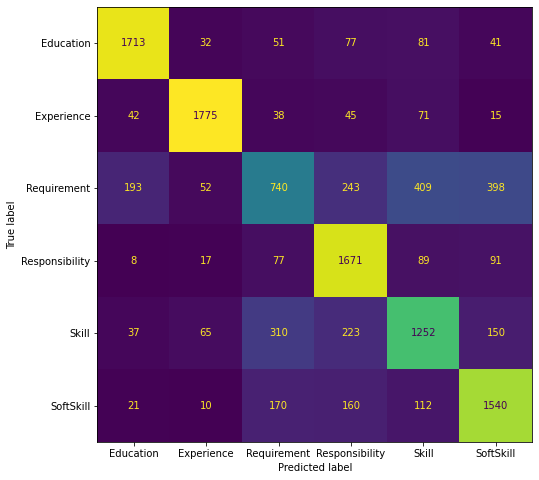

In [ ]:
#Generate & Display Confusion Matrix
display_labels_converter = ["Education", "Experience", "Requirement", "Responsibility", "Skill", "SoftSkill"]
cm = confusion_matrix(preds_in_pandas['ground_truth'], preds_in_pandas['prediction'])
dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels_converter)

plt.rcParams['figure.figsize'] = [8, 8]
display(dist.plot(colorbar=False))